In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as f_vision

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [12]:
transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(root='./data/train/', transform=transform)
test_dataset = datasets.ImageFolder(root='./data/test/', transform=transform)

In [13]:
#Dataloaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=2)

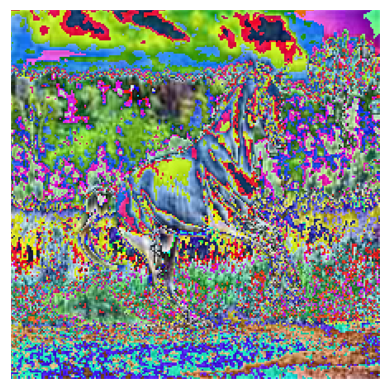

In [14]:
#check dataloader

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = f_vision.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


for x_train, y_train in train_loader:
    break

show(x_train[0])

In [15]:
def conv_depthwise(inp, oup, stride):
    return nn.Sequential(
        # dw
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),

        # pw
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True),
)


class MobileNet(nn.Module):
    def __init__(self, inp_channels: int, num_classes: int):
        super().__init__()

        self.input_layer = nn.Sequential(nn.Conv2d(in_channels=inp_channels, out_channels=32, kernel_size=3, padding=1, stride=2, bias=False),
                                         nn.ReLU(inplace=True),
                                         nn.BatchNorm2d(32))

        self.features = nn.Sequential(conv_depthwise(inp=32, oup=64, stride=1),
                                      conv_depthwise(inp=64, oup=128, stride=2),
                                      conv_depthwise(inp=128, oup=128, stride=1),
                                      conv_depthwise(inp=128, oup=256, stride=2),
                                      conv_depthwise(inp=256, oup=256, stride=1),
                                      conv_depthwise(inp=256, oup=512, stride=2),
                                      conv_depthwise(inp=512, oup=512, stride=1),
                                      conv_depthwise(inp=512, oup=512, stride=1),
                                      conv_depthwise(inp=512, oup=512, stride=1),
                                      conv_depthwise(inp=512, oup=512, stride=1),
                                      conv_depthwise(inp=512, oup=512, stride=1),
                                      conv_depthwise(inp=512, oup=1024, stride=2),
                                      conv_depthwise(inp=1024, oup=1024, stride=1))

        self.avg1 = nn.AvgPool2d(kernel_size=1)
        self.fc1 = nn.Linear(in_features=1024*7*7, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.input_layer(x)
        x = self.features(x)
        x = self.avg1(x)
        x = x.view(-1, 1024*7*7)
        x = self.fc1(x)
        return self.softmax(x)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
#train phase

model = MobileNet(inp_channels=3, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)
epoch = 2
for _ in range(epoch):
    for x_train, y_train in train_loader:

        x_train, y_train = x_train.to(device), y_train.to(device)
        y_pred = model(x_train)
        optimizer.zero_grad()
        loss = criterion(y_pred, y_train)
        print('loss', loss)
        loss.backward()
        optimizer.step()

loss tensor(0.7081, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.7143, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.7221, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.5823, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.6204, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.5947, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.6976, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.5832, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.6521, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.5723, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.5904, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.7184, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.5932, device='cuda:0', grad_fn=<NllLossBackward0>)
loss tensor(0.6165, devic

In [29]:
#model summary
from torchsummary import summary
summary(model, (3, 224, 224), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 32, 112, 112]             864
              ReLU-2          [1, 32, 112, 112]               0
       BatchNorm2d-3          [1, 32, 112, 112]              64
            Conv2d-4          [1, 32, 112, 112]             288
       BatchNorm2d-5          [1, 32, 112, 112]              64
              ReLU-6          [1, 32, 112, 112]               0
            Conv2d-7          [1, 64, 112, 112]           2,048
       BatchNorm2d-8          [1, 64, 112, 112]             128
              ReLU-9          [1, 64, 112, 112]               0
           Conv2d-10            [1, 64, 56, 56]             576
      BatchNorm2d-11            [1, 64, 56, 56]             128
             ReLU-12            [1, 64, 56, 56]               0
           Conv2d-13           [1, 128, 56, 56]           8,192
      BatchNorm2d-14           [1, 128,

In [40]:
# evaluation
from torchmetrics import Accuracy

accuracy = Accuracy(task='multiclass', num_classes=2).to(device)

for x_text, y_test in test_loader:

    x_text, y_test = x_text.to(device), y_test.to(device)
    y_test_pred = model(x_text)


    print(f'Accuracy -> {round(accuracy(y_test_pred, y_test).item(), ndigits=4)}')

Accuracy -> 0.7
Accuracy -> 0.8
Accuracy -> 0.8
Accuracy -> 0.7
Accuracy -> 0.7
Accuracy -> 0.6
Accuracy -> 0.4
Accuracy -> 0.3
Accuracy -> 0.6
